# U-Net model 


In [ ]:

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate


In [43]:
import os
import numpy as np
import albumentations as A
import cv2
from images_prepare import pre_images
from masks_prepare import pre_masks, pre_splitted_masks
from vgg16_model import UNET_VGG16


## Data preparation 

each x-ray image and mask would be preprocessed in images_prepare.py and masks_prepare.

In [ ]:
# Define paths
base_path = "/Teeth-Segmentation-project/SegNet-VGG16 "
data_path = os.path.join(base_path, "Data")

# Load images
resize_shape = (512, 512)
include_zip = False  # Change to True if data is still in the zip file

X, X_sizes = pre_images(resize_shape, data_path)

# Prepare masks
# Y = pre_masks(resize_shape=(512, 512), path=os.path.join(base_path, "Original_Masks"))
Y = pre_splitted_masks(path=os.path.join(base_path, "Custom_Masks"))

# Normalize images and masks
X = np.float32(X / 255.0)
Y = np.float32(Y / 255.0)
    
num_samples = 30
x_train = X[:num_samples, :, :, :]
y_train = Y[:num_samples, :, :, :]
x_test = X[105:, :, :, :]
y_test = Y[105:, :, :, :]

print("Data preparation completed.")

Data preparation completed.


In [45]:
import cv2
import albumentations as A
import numpy as np

# Augmentation pipeline - Similar to the original code
aug = A.Compose([
    A.OneOf([
        A.RandomCrop(width=512, height=512),
        A.PadIfNeeded(min_height=512, min_width=512, p=0.5)
    ], p=0.4),
    
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.5),
    
    A.OneOf([
        A.RandomScale(scale_limit=(-0.15, 0.15), p=1, interpolation=1),
        A.PadIfNeeded(512, 512, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.Resize(512, 512, interpolation=cv2.INTER_NEAREST)
    ], p=0.5),
    
    A.ShiftScaleRotate(shift_limit=0.325, scale_limit=0.15, rotate_limit=15, border_mode=cv2.BORDER_CONSTANT, p=1),
    A.Rotate(15, p=0.5),
    A.Blur(blur_limit=1, p=0.5),
    A.Downscale(scale_min=0.15, scale_max=0.25, p=0.5),
    A.GaussNoise(var_limit=(0.05, 0.1), mean=0, per_channel=True, p=0.5),
    A.HorizontalFlip(p=0.25),
    A.Resize(512, 512, interpolation=cv2.INTER_LINEAR)
])

# Initialize augmented data arrays
x_train1 = np.copy(x_train)
y_train1 = np.copy(y_train)

count = 0
while count < 1:  # Apply augmentation 1 time as in the original code
    x_aug2 = np.copy(x_train1)
    y_aug2 = np.copy(y_train1)
    
    for i in range(len(x_train1)):
        # Perform the augmentation for each image and corresponding mask
        augmented = aug(image=x_train1[i, :, :, :], mask=y_train1[i, :, :, :])
        x_aug2[i, :, :, :] = augmented['image']
        y_aug2[i, :, :, :] = augmented['mask']
    
    # Concatenate augmented data to the original dataset
    x_train = np.concatenate((x_train, x_aug2))
    y_train = np.concatenate((y_train, y_aug2))
    
    count += 1  


In [46]:
x_train.shape
y_train.shape

(60, 512, 512, 1)

In [47]:
#For Relase unneccasery memory
del x_aug2
del X
del Y
del y_aug2
del y_train1
del x_train1
del augmented

In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

def UNET_VGG16(input_shape=(512, 512, 3), last_activation='sigmoid'):
    # Input layer: Accepts a 512x512 RGB image
    inputs = Input(shape=input_shape)

    # Load the VGG16 model, pretrained on ImageNet, with the top (fully connected layers) removed
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)

    # Freeze VGG16 layers to prevent them from being updated during training
    for layer in vgg16.layers:
        layer.trainable = False

    # Encoder (Feature Extraction) using VGG16 layers

    # First block of VGG16: Detects low-level features like edges
    skip1 = vgg16.get_layer("block1_conv2").output  # Shape: (256, 256, 64)

    # Second block of VGG16: Detects slightly more complex features, such as textures
    skip2 = vgg16.get_layer("block2_conv2").output  # Shape: (128, 128, 128)

    # Third block of VGG16: Detects higher-level patterns, such as corners or curves
    skip3 = vgg16.get_layer("block3_conv3").output  # Shape: (64, 64, 256)

    # Fourth block of VGG16: Detects more abstract shapes and patterns
    skip4 = vgg16.get_layer("block4_conv3").output  # Shape: (32, 32, 512)

    # Fifth block of VGG16: Final encoder output; captures the most complex and abstract features
    encoder_output = vgg16.get_layer("block5_conv3").output  # Shape: (16, 16, 512)

    # Decoder (Reconstruction Path)

    # First decoder block: Upsamples the encoded features to a higher resolution
    x = UpSampling2D((2, 2))(encoder_output)  # Upsample from (16, 16) to (32, 32)
    x = concatenate([x, skip4])  # Combine with skip connection from encoder (32, 32, 512 + 512 = 1024 channels)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)  # Convolution to refine features
    x = BatchNormalization()(x)  # Normalizes activations to stabilize training
    x = Dropout(0.3)(x)  # Reduces overfitting by randomly dropping out neurons
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Second decoder block: Further upsampling
    x = UpSampling2D((2, 2))(x)  # Upsample from (32, 32) to (64, 64)
    x = concatenate([x, skip3])  # Combine with skip connection from encoder (64, 64, 256 + 256 = 512 channels)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Third decoder block: Continue upsampling
    x = UpSampling2D((2, 2))(x)  # Upsample from (64, 64) to (128, 128)
    x = concatenate([x, skip2])  # Combine with skip connection from encoder (128, 128, 128 + 128 = 256 channels)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Fourth decoder block: Upsample again
    x = UpSampling2D((2, 2))(x)  # Upsample from (128, 128) to (256, 256)
    x = concatenate([x, skip1])  # Combine with skip connection from encoder (256, 256, 64 + 64 = 128 channels)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Final decoder block: No further upsampling needed, output size should now match input size (512, 512)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)  # Further reduce channels for final layer
    x = BatchNormalization()(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)

    # Output layer: 1x1 convolution to create a single-channel output with the same spatial size as input
    outputs = Conv2D(1, (1, 1), activation=last_activation, padding='same')(x)  # Shape: (512, 512, 1)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Create the model
model = UNET_VGG16(input_shape=(512, 512, 3))

# Display model summary to check layer shapes
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Ensure x_train and y_train have the correct shapes and types
# x_train: should be (num_samples, 512, 512, 3)
# y_train: should be (num_samples, 512, 512, 1) with binary values for segmentation

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=20, verbose=1)



Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 512, 512,  │      1,792 │ input_layer_11[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 512, 512,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 256, 256,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 256, 256,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 256, 256,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 128, 128,  │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 128, 128,  │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 128, 128,  │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 128, 128,  │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 64, 64,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 64, 64,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 64, 64,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 64, 64,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 32, 32,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 32, 32,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 32, 32,    │  2,359,808 │ block5_conv1[0][

 Total params: 18,643,313 (71.12 MB)

 Trainable params: 3,926,673 (14.98 MB)

 Non-trainable params: 14,716,640 (56.14 MB)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.7547 - loss: 0.4145
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8765 - loss: 0.1828
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8855 - loss: 0.1683
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.8853 - loss: 0.1506
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8879 - loss: 0.1451
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8887 - loss: 0.1468
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8975 - loss: 0.1251
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9027 - loss: 0.1208
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8960 - loss: 0.1173
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9013 - loss: 0.1129
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9074 - loss: 0.1032
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0

In [ ]:
model.save('unet_vgg16_teeth_segmentation_v1.keras')

""" from tensorflow.keras.models import load_model
model = load_model('unet_vgg16_teeth_segmentation_v1.keras') """

""" baseline_model = tf.keras.models.load_model('unet_vgg16_teeth_segmentation_v1.keras')
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) """


" baseline_model = tf.keras.models.load_model('unet_vgg16_teeth_segmentation_v1.keras')\nbaseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) "

In [37]:
import tensorflow as tf
import numpy as np

# Define the Dice score metric
def dice_score(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# Load the model
model = tf.keras.models.load_model('unet_vgg16_teeth_segmentation_v1.keras')

# Evaluate the model on test data and calculate Dice score
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(np.float32)  # Apply threshold for binary segmentation

# Calculate Dice score for each test sample
dice_scores = [dice_score(y_test[i], y_pred[i]) for i in range(len(y_test))]
average_dice_score = np.mean(dice_scores)

print("Average Dice Score:", average_dice_score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Average Dice Score: 0.8692413


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


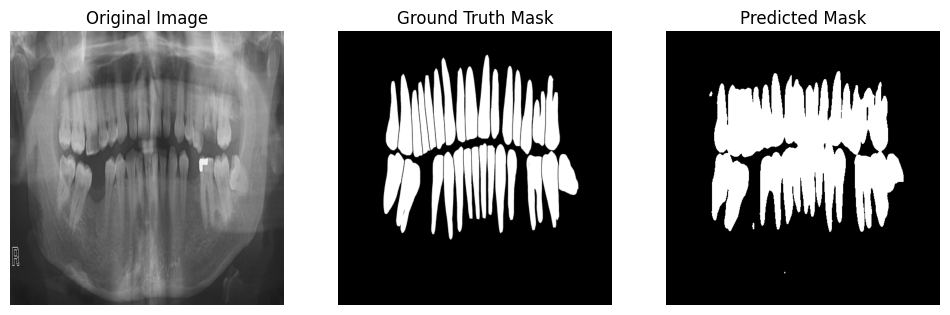

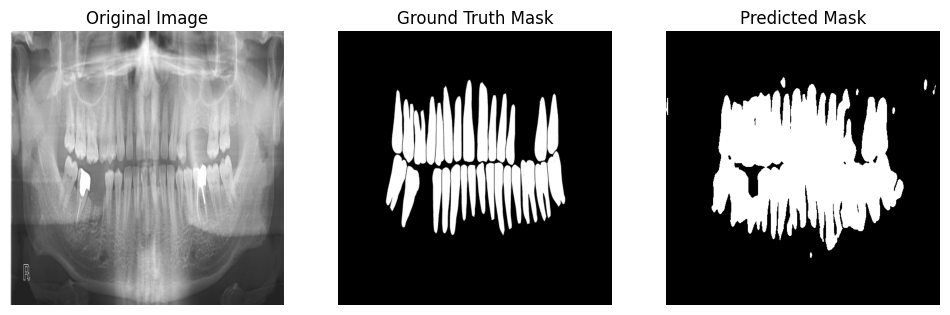

In [38]:
import matplotlib.pyplot as plt

# Get predictions for the test set
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(np.float32)  # Apply threshold to get binary predictions

# Choose two sample indices to visualize
sample_indices = [0, 1]  # You can change these indices to visualize different samples

# Plot the original image, ground truth, and predicted mask for each sample
for idx in sample_indices:
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(x_test[idx])
    plt.title("Original Image")
    plt.axis('off')

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[idx].squeeze(), cmap='gray')  # Squeeze to remove channel dimension for display
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(y_pred[idx].squeeze(), cmap='gray')  # Squeeze to remove channel dimension for display
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


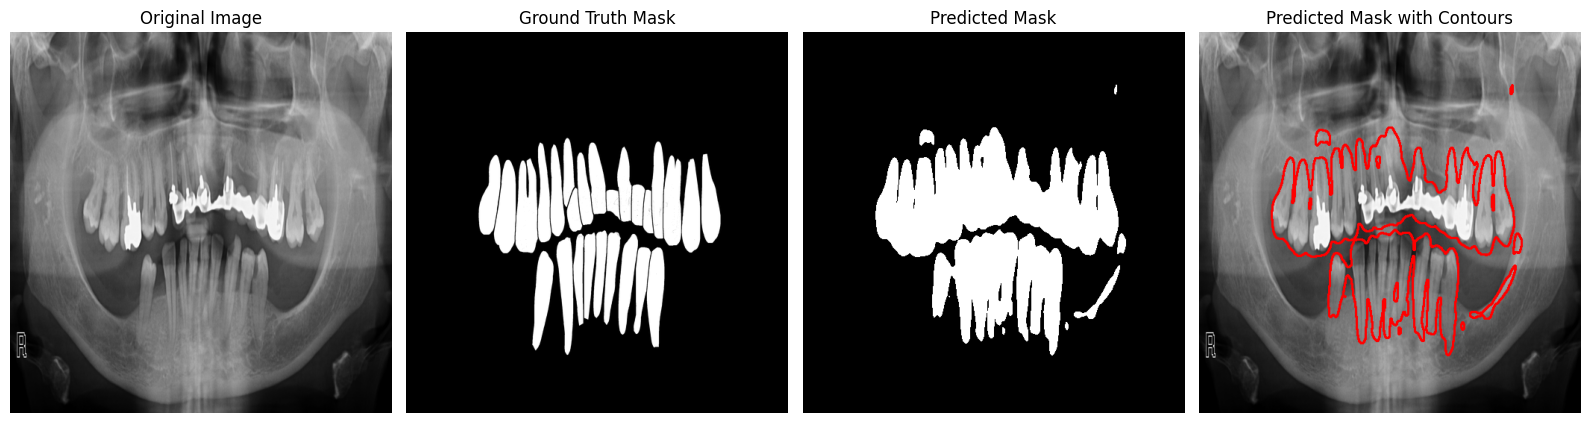

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


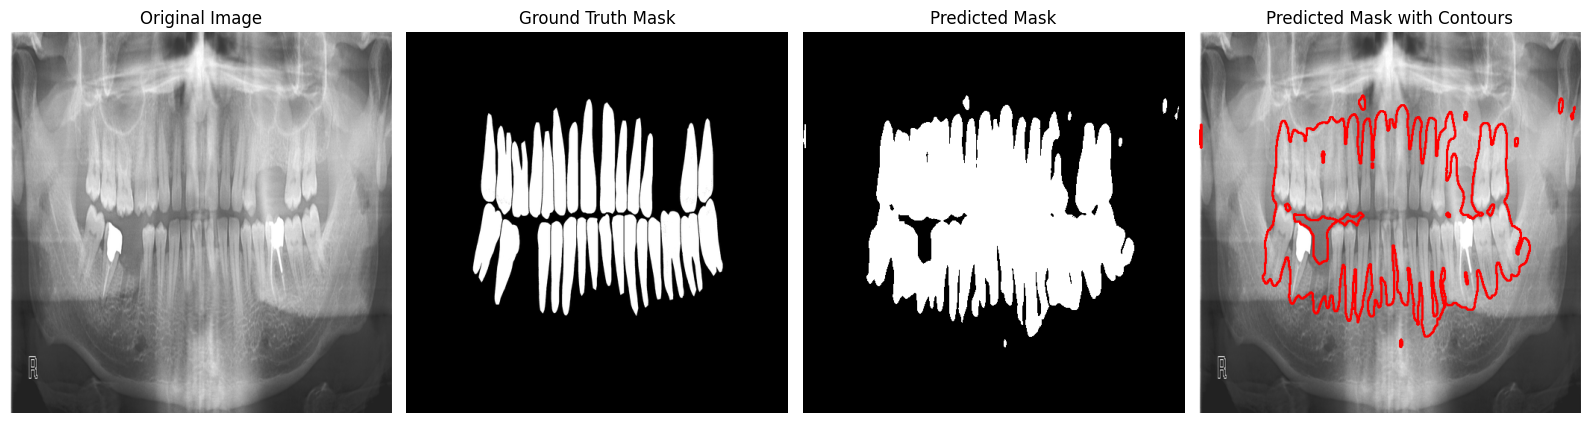

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained U-Net model
model = load_model('unet_vgg16_teeth_segmentation_v1.keras')

# Generate predictions
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(np.uint8)  # Convert to binary mask

# Function to display bounding boxes/contours on the predicted mask
def show_contours_with_bounding_box(original_image, binary_mask, title="Predicted Mask with Contours"):
    # Resize the predicted mask to match the original image size if necessary
    resized_mask = cv2.resize(binary_mask, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_LANCZOS4)

    # Convert the binary mask to 8-bit and find contours
    mask = (resized_mask * 255).astype(np.uint8)
    _, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on a copy of the original image
    contoured_image = original_image.copy()
    cv2.drawContours(contoured_image, contours, -1, (255, 0, 0), 1)  # Red color for contours

    return contoured_image

# Visualize each element separately
sample_indices = [2, 1]  # Example indices; adjust as needed

for idx in sample_indices:
    original_image = x_test[idx]  # Original test image
    ground_truth_mask = y_test[idx].squeeze()  # Ground truth mask
    predicted_mask = y_pred_binary[idx, :, :, 0]  # Predicted binary mask
    contoured_image = show_contours_with_bounding_box(original_image, predicted_mask)

    # Plot each component in a separate subplot
    plt.figure(figsize=(16, 8))

    # Original image
    plt.subplot(1, 4, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    # Ground truth mask
    plt.subplot(1, 4, 2)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Predicted binary mask
    plt.subplot(1, 4, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    # Predicted mask with contours
    plt.subplot(1, 4, 4)
    plt.imshow(contoured_image, cmap='gray')
    plt.title("Predicted Mask with Contours")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
